In [74]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, \
precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import itertools
# show all columns when displaying a data frame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Preparation and Train-Test-Split

In [46]:
dtypes = {'country':'category', 'cat_name':'category', 'cat_slug':'category', 'loc_name':'category', 
'loc_country':'category', 'loc_state':'category', 'loc_type':'category', 'main_category':'category', 
'sub_category':'category', 'goal_categorical':'category', 'currency':'category', 'usd_type':'category'}
frame_all = pd.read_csv('data/Kickstarter_full.csv', index_col=0, parse_dates=['created_at', 'launched_at', 'deadline', 'state_changed_at'], dtype=dtypes)

In [47]:
columns = frame_all.columns

In [48]:
to_delete = ['backers_count',
 'blurb',
 'created_at',
 'converted_pledged_amount',
 'currency_symbol',
 'currency_trailing_code',
 'current_currency',
 'deadline',
 'goal',
 'id',
 'is_starrable',
 'launched_at',
 'name',
 'pledged',
 'slug',
 'source_url',
 'spotlight',
 'staff_pick',
 'state',
 'state_changed_at',
 'usd_pledged',
 'cat_name',
 'cat_slug',
 'loc_name',
 'loc_country',
 'loc_state',
 'photo_thumb',
 'photo_large',
 'project_address',
 'profile_photo',
 'creator_name',
 'creator_id',
 'creator_thumb',
 'creator_address',
 'goal_surpass',
 'goal_surpass_share',
 'goal_surpass_usd',
 'baseline',
 'disable_communication',
 'dur_until_state_changed',
 'dur_ratio',
 'goal_usd',
 'blurb_words',
 'name_words',
 'fx_rate',
 'static_usd_rate']

 # Additionally deleted: 
# Cannot be known a priori: 'dur_until_state_changed', 'dur_ratio'
# Somehow a duplicate: 'goal_usd', 'blurb_words', 'name_words'
# For other reasons: 'fx_rate', 'static_usd_rate'

In [49]:
frame_all.drop(columns=to_delete, inplace=True)

In [50]:
# Save category-column-names in list
categorical_cols = frame_all.select_dtypes(include='category').columns

# save numerical features in a list
num_features = frame_all.select_dtypes(include='number').columns.to_list()
num_features.remove('state_bool')

# create dummies
frame_all = pd.get_dummies(frame_all, columns = categorical_cols, drop_first=True)


In [51]:
X = frame_all.drop('state_bool', axis=1)
y = frame_all.state_bool

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Scaling

In [53]:
# scale the (few) numerical features
std = StandardScaler()
X_train_scaled = X_train.copy(deep=True)
X_test_scaled = X_test.copy(deep=True)
X_train_scaled[num_features] = std.fit_transform(X_train_scaled[num_features])
X_test_scaled[num_features] = std.transform(X_test_scaled[num_features])

## Vanilla Logistic Regression

In [56]:
log_reg = LogisticRegression(verbose=1)
log_reg.fit(X_train_scaled, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          215     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76880D+04    |proj g|=  9.69848D+03

At iterate   50    f=  5.71325D+04    |proj g|=  7.60891D+02

At iterate  100    f=  5.64742D+04    |proj g|=  1.20108D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  215    100    108      1     0     0   1.201D+02   5.647D+04
  F =   56474.205061213062     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


LogisticRegression(verbose=1)

In [59]:
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)

In [58]:
# Function to plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 15)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)


Confusion matrix, without normalization
[[42966 12628]
 [16364 54549]]


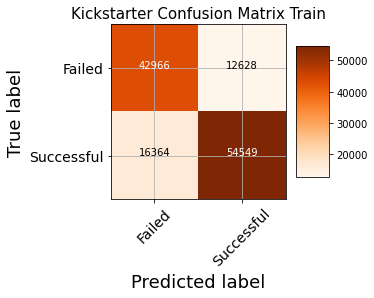

In [64]:
cm_train = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(cm_train, classes = ['Failed','Successful'],
                      title = 'Kickstarter Confusion Matrix Train')

Confusion matrix, without normalization
[[14285  4247]
 [ 5538 18100]]


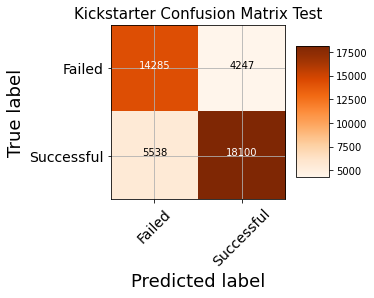

In [65]:
cm_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_test, classes = ['Failed','Successful'],
                      title = 'Kickstarter Confusion Matrix Test')

In [67]:
cr_train = classification_report(y_train, y_pred_train)
print('Classification on train data')
print(cr_train)

Classification on train data
              precision    recall  f1-score   support

           0       0.72      0.77      0.75     55594
           1       0.81      0.77      0.79     70913

    accuracy                           0.77    126507
   macro avg       0.77      0.77      0.77    126507
weighted avg       0.77      0.77      0.77    126507



In [68]:
cr_test = classification_report(y_test, y_pred_test)
print('Classification on test data')
print(cr_test)

Classification on test data
              precision    recall  f1-score   support

           0       0.72      0.77      0.74     18532
           1       0.81      0.77      0.79     23638

    accuracy                           0.77     42170
   macro avg       0.77      0.77      0.77     42170
weighted avg       0.77      0.77      0.77     42170



## Hyperparameter Optimization

In [81]:
# Hyperparameter grid
param_grid = {
    'random_state': [42],
    'max_iter': [1000],
    'solver': ['saga'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.1, 1.25, 1.5, 2.0, 5.0, 10.0, 100.0],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]
}

In [82]:
estimator = LogisticRegression(random_state=42, max_iter=1000)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 10, verbose = 5, random_state=42)

# Fit 
rs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.771 total time= 5.9min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.770 total time= 6.0min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.766 total time= 6.0min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.774 total time= 6.0min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.768 total time= 6.0min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1.1, class_weight=balanced, fit_intercept=False, l1_ratio=0.1, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.766 total time= 6.5min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1.1, class_weight=balanced, fit_intercept=False, l1_ratio=0.1, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.765 total time= 6.5min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1.1, class_weight=balanced, fit_intercept=False, l1_ratio=0.1, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.766 total time= 6.6min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100.0, class_weight=None, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.768 total time= 6.3min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100.0, class_weight=None, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.771 total time= 6.4min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100.0, class_weight=None, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.771 total time= 6.4min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1.1, class_weight=balanced, fit_intercept=False, l1_ratio=0.1, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.770 total time= 7.1min
[CV 4/5] END C=100.0, class_weight=None, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.767 total time= 6.6min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/lennartmarien/Documents/neuefisch

[CV 5/5] END C=100.0, class_weight=None, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.775 total time= 6.6min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.768 total time= 6.6min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=1.1, class_weight=balanced, fit_intercept=False, l1_ratio=0.1, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.763 total time= 7.2min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=2.0, class_weight=balanced, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=none, random_state=42, solver=saga;, score=0.765 total time= 4.7min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=2.0, class_weight=balanced, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=none, random_state=42, solver=saga;, score=0.767 total time= 4.7min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=2.0, class_weight=balanced, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=none, random_state=42, solver=saga;, score=0.766 total time= 4.8min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END C=2.0, class_weight=balanced, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=none, random_state=42, solver=saga;, score=0.763 total time= 4.8min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.770 total time= 7.7min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.771 total time= 7.7min
[CV 4/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.767 total time= 7.7min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END C=0.05, class_weight=balanced, fit_intercept=True, l1_ratio=0.1, max_iter=1000, penalty=l2, random_state=42, solver=saga;, score=0.759 total time=  23.8s


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=5.0, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.774 total time= 7.5min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END C=0.05, class_weight=balanced, fit_intercept=True, l1_ratio=0.1, max_iter=1000, penalty=l2, random_state=42, solver=saga;, score=0.763 total time=  28.0s


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END C=0.05, class_weight=balanced, fit_intercept=True, l1_ratio=0.1, max_iter=1000, penalty=l2, random_state=42, solver=saga;, score=0.762 total time=  27.6s


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END C=0.05, class_weight=balanced, fit_intercept=True, l1_ratio=0.1, max_iter=1000, penalty=l2, random_state=42, solver=saga;, score=0.757 total time=  16.6s
[CV 5/5] END C=0.05, class_weight=balanced, fit_intercept=True, l1_ratio=0.1, max_iter=1000, penalty=l2, random_state=42, solver=saga;, score=0.765 total time=  25.1s
[CV 1/5] END C=0.3, class_weight=balanced, fit_intercept=False, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.763 total time= 2.6min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=2.0, class_weight=balanced, fit_intercept=True, l1_ratio=0.75, max_iter=1000, penalty=none, random_state=42, solver=saga;, score=0.770 total time= 6.1min
[CV 2/5] END C=0.3, class_weight=balanced, fit_intercept=False, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.766 total time= 2.6min
[CV 4/5] END C=0.3, class_weight=balanced, fit_intercept=False, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.763 total time= 1.3min
[CV 3/5] END C=0.3, class_weight=balanced, fit_intercept=False, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.766 total time= 2.1min
[CV 5/5] END C=0.3, class_weight=balanced, fit_intercept=False, l1_ratio=0.25, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.770 total time= 2.0min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=2.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.768 total time= 8.8min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=2.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.770 total time= 8.8min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=2.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.770 total time= 8.7min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=2.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.774 total time= 8.5min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=2.0, class_weight=None, fit_intercept=True, l1_ratio=0.25, max_iter=1000, penalty=l1, random_state=42, solver=saga;, score=0.767 total time= 8.7min
[CV 1/5] END C=0.2, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.767 total time= 2.0min
[CV 4/5] END C=0.2, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.766 total time= 1.3min
[CV 2/5] END C=0.2, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.770 total time= 2.1min
[CV 3/5] END C=0.2, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.770 total time= 2.1min
[CV 5/5] END C=0.2, class_weight=None, fit_intercept=True, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.773 total 

/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10.0, class_weight=None, fit_intercept=False, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.768 total time= 7.0min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10.0, class_weight=None, fit_intercept=False, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.770 total time= 6.7min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10.0, class_weight=None, fit_intercept=False, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.771 total time= 6.6min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10.0, class_weight=None, fit_intercept=False, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.775 total time= 6.3min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10.0, class_weight=None, fit_intercept=False, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, random_state=42, solver=saga;, score=0.767 total time= 6.4min


/Users/lennartmarien/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3,
                                              0.4, 0.5, 0.75, 1.0, 1.1, 1.25,
                                              1.5, 2.0, 5.0, 10.0, 100.0],
                                        'class_weight': [None, 'balanced'],
                                        'fit_intercept': [True, False],
                                        'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                                        'max_iter': [1000],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'random_state': [42],
                                        'solver': ['saga']},
                   random_state=42, scoring='accuracy', verbose=5)

In [83]:
rs.best_params_

{'solver': 'saga',
 'random_state': 42,
 'penalty': 'elasticnet',
 'max_iter': 1000,
 'l1_ratio': 0.75,
 'fit_intercept': True,
 'class_weight': None,
 'C': 100.0}

In [84]:
best_model = rs.best_estimator_
y_pred_train_be = best_model.predict(X_train_scaled)
y_pred_test_be = best_model.predict(X_test_scaled)

Confusion matrix, without normalization
[[43219 12375]
 [16541 54372]]


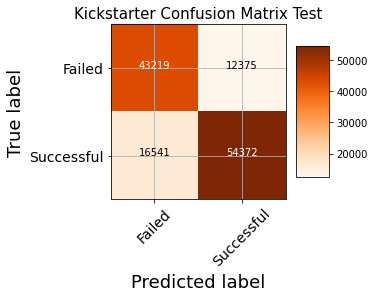

In [87]:
cm_train_be = confusion_matrix(y_train, y_pred_train_be)
plot_confusion_matrix(cm_train_be, classes = ['Failed','Successful'],
                      title = 'Kickstarter Confusion Matrix Test')

Confusion matrix, without normalization
[[14369  4163]
 [ 5627 18011]]


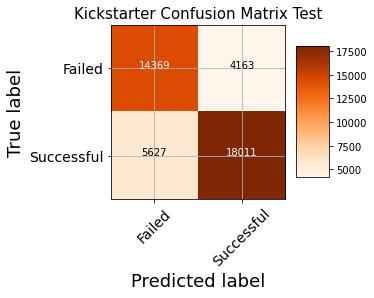

In [88]:
cm_test_be = confusion_matrix(y_test, y_pred_test_be)
plot_confusion_matrix(cm_test_be, classes = ['Failed','Successful'],
                      title = 'Kickstarter Confusion Matrix Test')

In [89]:
cr_train_be = classification_report(y_train, y_pred_train_be)
print('Classification on train data')
print(cr_train_be)

Classification on train data
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     55594
           1       0.81      0.77      0.79     70913

    accuracy                           0.77    126507
   macro avg       0.77      0.77      0.77    126507
weighted avg       0.77      0.77      0.77    126507



In [90]:
cr_test_be = classification_report(y_test, y_pred_test_be)
print('Classification on train data')
print(cr_test_be)

Classification on train data
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     18532
           1       0.81      0.76      0.79     23638

    accuracy                           0.77     42170
   macro avg       0.77      0.77      0.77     42170
weighted avg       0.77      0.77      0.77     42170

